In [25]:
import frouros

In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from frouros.datasets.real import Elec2
from frouros.detectors.concept_drift import DDM, DDMConfig

In [27]:
from frouros.datasets.synthetic import SEA
from frouros.detectors.concept_drift import DDM, DDMConfig
from frouros.metrics.prequential_error import PrequentialError
from sklearn.tree import DecisionTreeClassifier

# Training, warm-up and testing

In [28]:
random_state = 31

concept_samples = 20000
generator = SEA(seed=random_state)
noise = 0.0

reference_concept = generator.generate_dataset(
    block=1,  # Concept 1
    noise=noise,
    num_samples=concept_samples,
)

X_reference, y_reference = [], []
for sample, label in reference_concept:
    X_reference.append(sample)
    y_reference.append(label)
X_reference, y_reference = np.array(X_reference), np.array(y_reference).reshape(-1, 1)



In [29]:
## Shuffle data to avoid bias
idx = np.arange(len(X_reference))
np.random.shuffle(idx)
X_reference, y_reference = X_reference[idx], y_reference[idx]

split_idx = concept_samples // 2  # 10000 each subset (train and warmup)
X_train, y_train = X_reference[:split_idx], y_reference[:split_idx]
X_warmup, y_warmup = X_reference[split_idx:], y_reference[split_idx:]

In [30]:
test_concepts = [
    generator.generate_dataset(
        block=block,
        noise=noise,
        num_samples=10000,
    )
    for block in [1, 3]
]  # Concepts 1 and 3

X_test, y_test = [], []
for concept in test_concepts:
    for sample, label in concept:
        X_test.append(sample)
        y_test.append(label)

X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)

In [31]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(
        X_warmup
    ),  # Minimum number of instances to start checking for drift
)

detector = DDM(
    config=config,
)

In [32]:
model = DecisionTreeClassifier(
    random_state=random_state,
)
model.fit(
    X=X_train,
    y=y_train,
)

DecisionTreeClassifier(random_state=31)

In [33]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

In [34]:
def error_scorer(y_true, y_pred):  # Error function
    return 1 - (y_true.item() == y_pred.item())

In [188]:
## Warm up phase
# Warm-up detector
print(f"Warming up detector with {len(X_warmup)} samples")

for X, y in zip(X_warmup, y_warmup):
    y_pred = model.predict(X=X.reshape(1, -1))
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

Warming up detector with 10000 samples


In [36]:
metrics

[PrequentialError(name='α=1.0', alpha=1.0)]

In [37]:
## Testing Phase

idx_drift, idx_warning = [], []
i = len(X_warmup)
for X, y in zip(X_test, y_test):
    y_pred = model.predict(X=X.reshape(1, -1))  # Model's prediction
    error = error_scorer(y_true=y, y_pred=y_pred)
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    status = detector.status
    if status["drift"]:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
        detector.reset()  # Reset detector
        for metric in metrics:  # Reset metrics
            metric.reset()
        break  # Stop simulation
    elif status["warning"]:
        # Warning zone
        idx_warning.append(i)
    i += 1

Drift detected at index: 20299


In [40]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

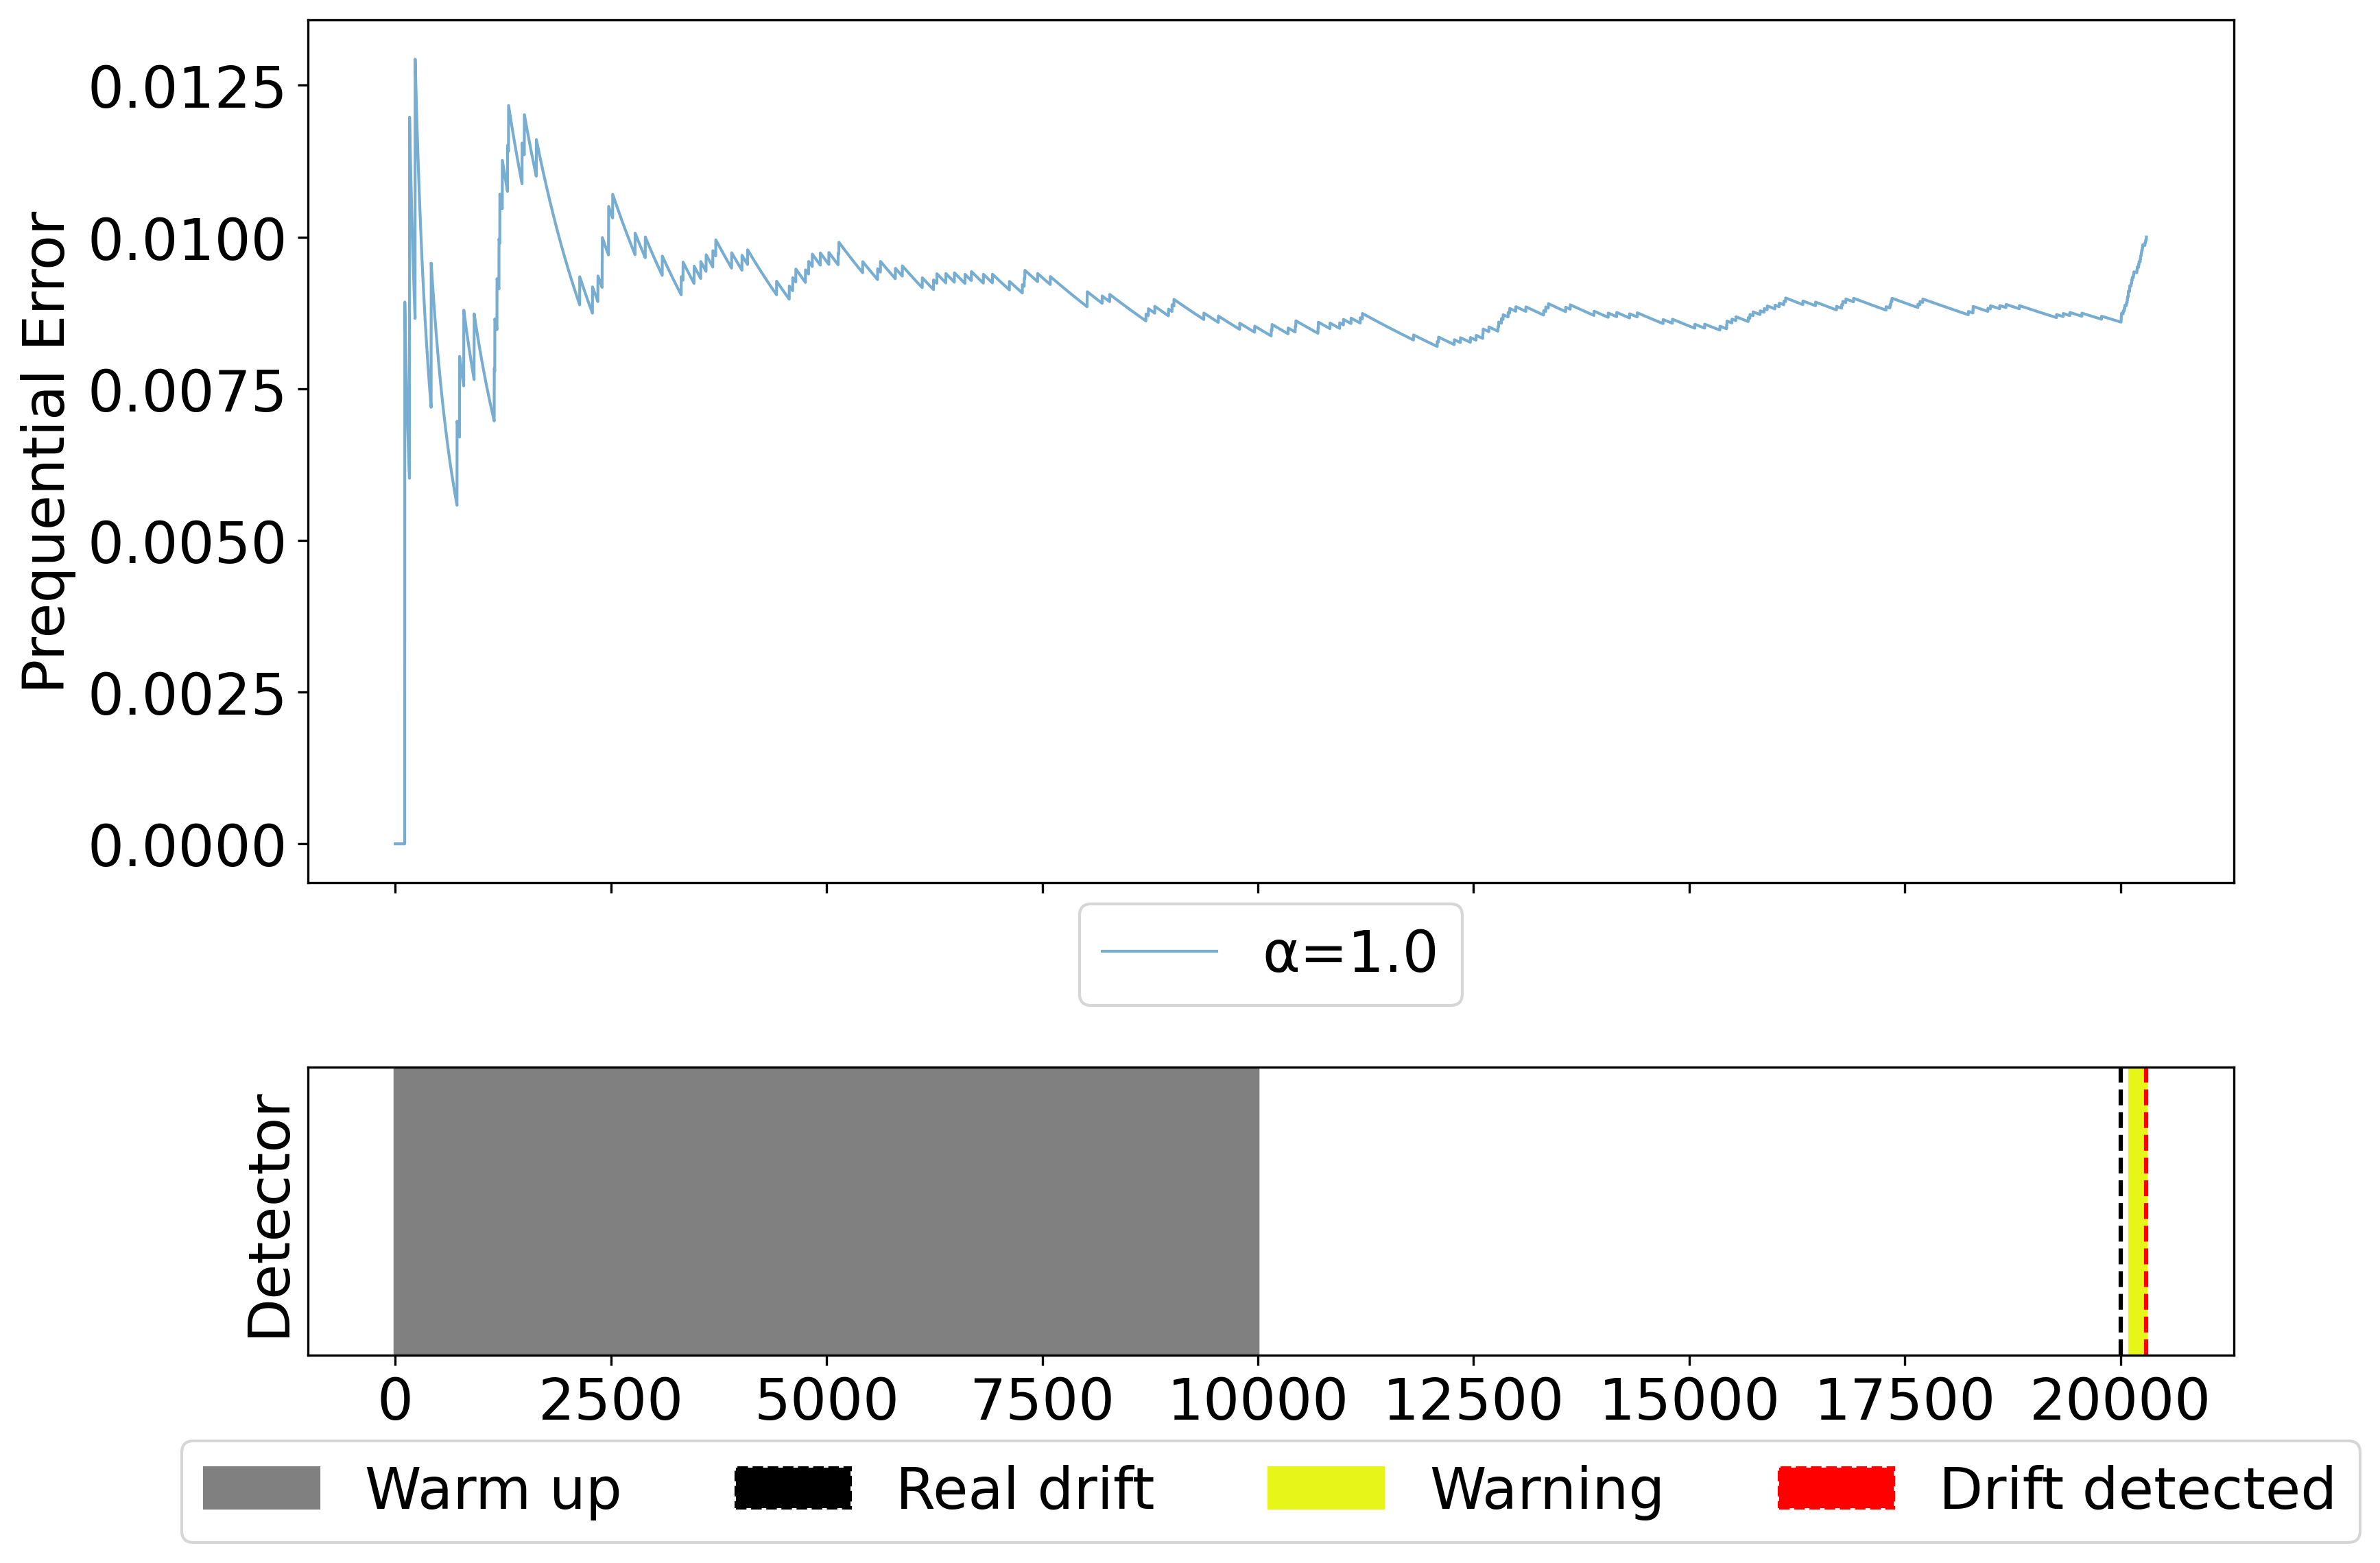

In [41]:
plt.rcParams.update({"font.size": 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={"height_ratios": [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
    metrics_historic_detector.items(),
    ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(
        metric_values,
        color=linecolor,
        linewidth=linewidth,
        alpha=alpha,
        label=metric_name,
    )

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"
warning_color = "#e8f519"
real_drift_color = "black"

for idx in range(0, len(X_warmup)):
    ax[1].axvline(x=idx, color=warmup_color, linewidth=linewidth)

for idx in idx_warning:
    ax[1].axvline(x=idx, color=warning_color, linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx, color=drift_color, linestyle=drift_linestyle, linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Detector")
drift_path = mpatches.Patch(
    color=drift_color, label="Drift detected", linestyle=drift_linestyle
)
warning_path = mpatches.Patch(color=warning_color, label="Warning")
warmup_path = mpatches.Patch(color=warmup_color, label="Warm up")
real_drift_path = mpatches.Patch(
    color=real_drift_color, label="Real drift", linestyle=drift_linestyle
)
ax[1].axvline(x=20000, color=real_drift_color, linestyle=drift_linestyle, linewidth=1.5)
ax[1].legend(
    handles=[warmup_path, real_drift_path, warning_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()

In [42]:
## Ver ainda hoje

from frouros.detectors.concept_drift import KSWIN, KSWINConfig
import numpy as np
np.random.seed(seed=31)
dist_a = np.random.normal(loc=0.2, scale=0.01, size=1000)
dist_b = np.random.normal(loc=0.8, scale=0.04, size=1000)
stream = np.concatenate((dist_a, dist_b))
detector = KSWIN(config=KSWINConfig(seed=63))
for i, value in enumerate(stream):
     _ = detector.update(value=value)
     if detector.drift:
         print(f"Change detected at step {i}")
         break

Change detected at step 1016


In [43]:
import pandas as pd
import numpy as np

In [44]:
data =np.load("13_fraud.npz", allow_pickle=True)

# %%
X, y = data['X'], data['y']

# %%
X_data = pd.DataFrame(X).copy()
X_data.columns = [f"feature_{k}" for k in X_data.columns]
X_data["gt"] = pd.Series(y)


In [45]:
from sklearn.model_selection import train_test_split

In [169]:
X_train,X_test = train_test_split(X_data, test_size=0.5, random_state=42)

In [170]:
feature = 'feature_2'

In [171]:
## split the X_test dataset into 20 pieces day by day


# Divide o dataframe em 20 partes iguais
df_splits = np.array_split(X_test, 10)

# Cria datas específicas para cada subconjunto
novas_datas = pd.date_range("2024-06-01", periods=10, freq='D')

# Associa uma nova data para cada conjunto e adiciona ao dataframe original
for i, subset in enumerate(df_splits):
    subset['data'] = novas_datas[i]

# Recombina todos os subconjuntos em um único DataFrame
df_final = pd.concat(df_splits, ignore_index=True)

c:\Users\geand\anaconda3\envs\analytics\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [172]:
X_train['data'] = 'base'

In [173]:
base_feature = X_train[feature]
current_date = '2024-06-01'
current_feature =df_final.query(f'data == "{current_date}"')[feature]

# agregate stats for each day comparing base and current
stats = {"mean_base": round(base_feature.mean(), 3), "mean_current": round(current_feature.mean(),3),
         "min_base": round(base_feature.min(), 3),   "min_current": round(current_feature.min(), 3),
         "max_base": round(base_feature.max(), 3),   "max_current": round(current_feature.max(), 3),
         "percentile_90_base": round(base_feature.quantile(0.9), 3),  "percentile_90_current": round(current_feature.quantile(0.9), 3),
         "percentile_10_base": round(base_feature.quantile(0.1), 3),   "percentile_10_current": round(current_feature.quantile(0.1), 3),
         "percentile_25_base": round(base_feature.quantile(0.25), 3),   "percentile_25_current": round(current_feature.quantile(0.25), 3)}

C:\Users\geand\AppData\Local\Temp\ipykernel_8916\1982170693.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  current_feature =df_final.query(f'data == "{current_date}"')[feature]


In [174]:
def error_functions(stats,anomaly_type):
   if anomaly_type=="mean_base":
        if stats["mean_current"]>stats["mean_base"]:
            return 1
        else:
            return 0
   elif anomaly_type=="min_base":
        if stats["min_current"]<stats["min_base"]:
            return 1
        else:
            return 0
   elif anomaly_type=="max_base":
        if stats["max_current"]>stats["max_base"]:
            return 1
        else:
            return 0
   elif anomaly_type=="percentile_90_base":
        if stats["percentile_90_current"]>stats["percentile_90_base"]:
            return 1
        else:
            return 0
   elif anomaly_type=="percentile_10_base":
        if stats["percentile_10_current"]>stats["percentile_10_base"]:
            return 1
        else:
            return 0    
   elif anomaly_type=="percentile_25_base":
        if stats["percentile_25_current"]>stats["percentile_25_base"]:
            return 1
        else:
            return 0
   else:
        return 0


In [175]:
X_train = X_train.sample(frac=0.1)

In [176]:
config = DDMConfig(
    warning_level=2.0,
    drift_level=3.0,
    min_num_instances=len(
        X_train
    ),  # Minimum number of instances to start checking for drift
)

detector = DDM(
    config=config,
)

In [177]:
metrics = [
    PrequentialError(
        alpha=alpha,
        name=f"α={alpha}",
    )
    for alpha in [1.0,0.9999,0.99]
]
metrics_historic_detector = {f"{metric.name}": [] for metric in metrics}

In [178]:
## Warm up phase
# Warm-up detector
print(f"Warming up detector with {len(X_train)} samples")


base_feature = X_train[feature]
current_date = 'base'
current_feature =X_train.query(f'data == "{current_date}"')[feature]

# agregate stats for each day comparing base and current
stats = {"mean_base": round(base_feature.mean(), 3), "mean_current": 0,
         "min_base": round(base_feature.min(), 3),   "min_current": 0,
         "max_base": round(base_feature.max(), 3),   "max_current": 0,
         "percentile_90_base": round(base_feature.quantile(0.9), 3),  "percentile_90_current": 0,
         "percentile_10_base": round(base_feature.quantile(0.1), 3),   "percentile_10_current": 0,
         "percentile_25_base": round(base_feature.quantile(0.25), 3),   "percentile_25_current": 0}

for index, row in X_train[[feature]].iterrows():
    X_mean = row.mean()
    stats["mean_current"] = X_mean
    error = error_functions(stats,'mean_base')
    _ = detector.update(value=error)
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

Warming up detector with 14240 samples


In [ ]:
## Testing Phase

idx_drift = []
i = len(X_train)
for date in novas_datas:
    X_mean = df_final.query("data == @date")[feature].mean()
    stats["mean_current"] = X_mean
    error = error_functions(stats,'mean_base')
    _ = detector.update(value=error)  # Detector's update

    # All the following lines are optional and only used for plotting the whole process
    for metric_historic, metric in zip(metrics_historic_detector.keys(), metrics):
        metrics_historic_detector[metric_historic].append(metric(error))

    if error:
        # Drift detected
        print(f"Drift detected at index: {i}")
        idx_drift.append(i)
    i += 1

In [ ]:
### idx_drift quantidade de anomalias detectadas pela metrica mean_current para um dia especifico

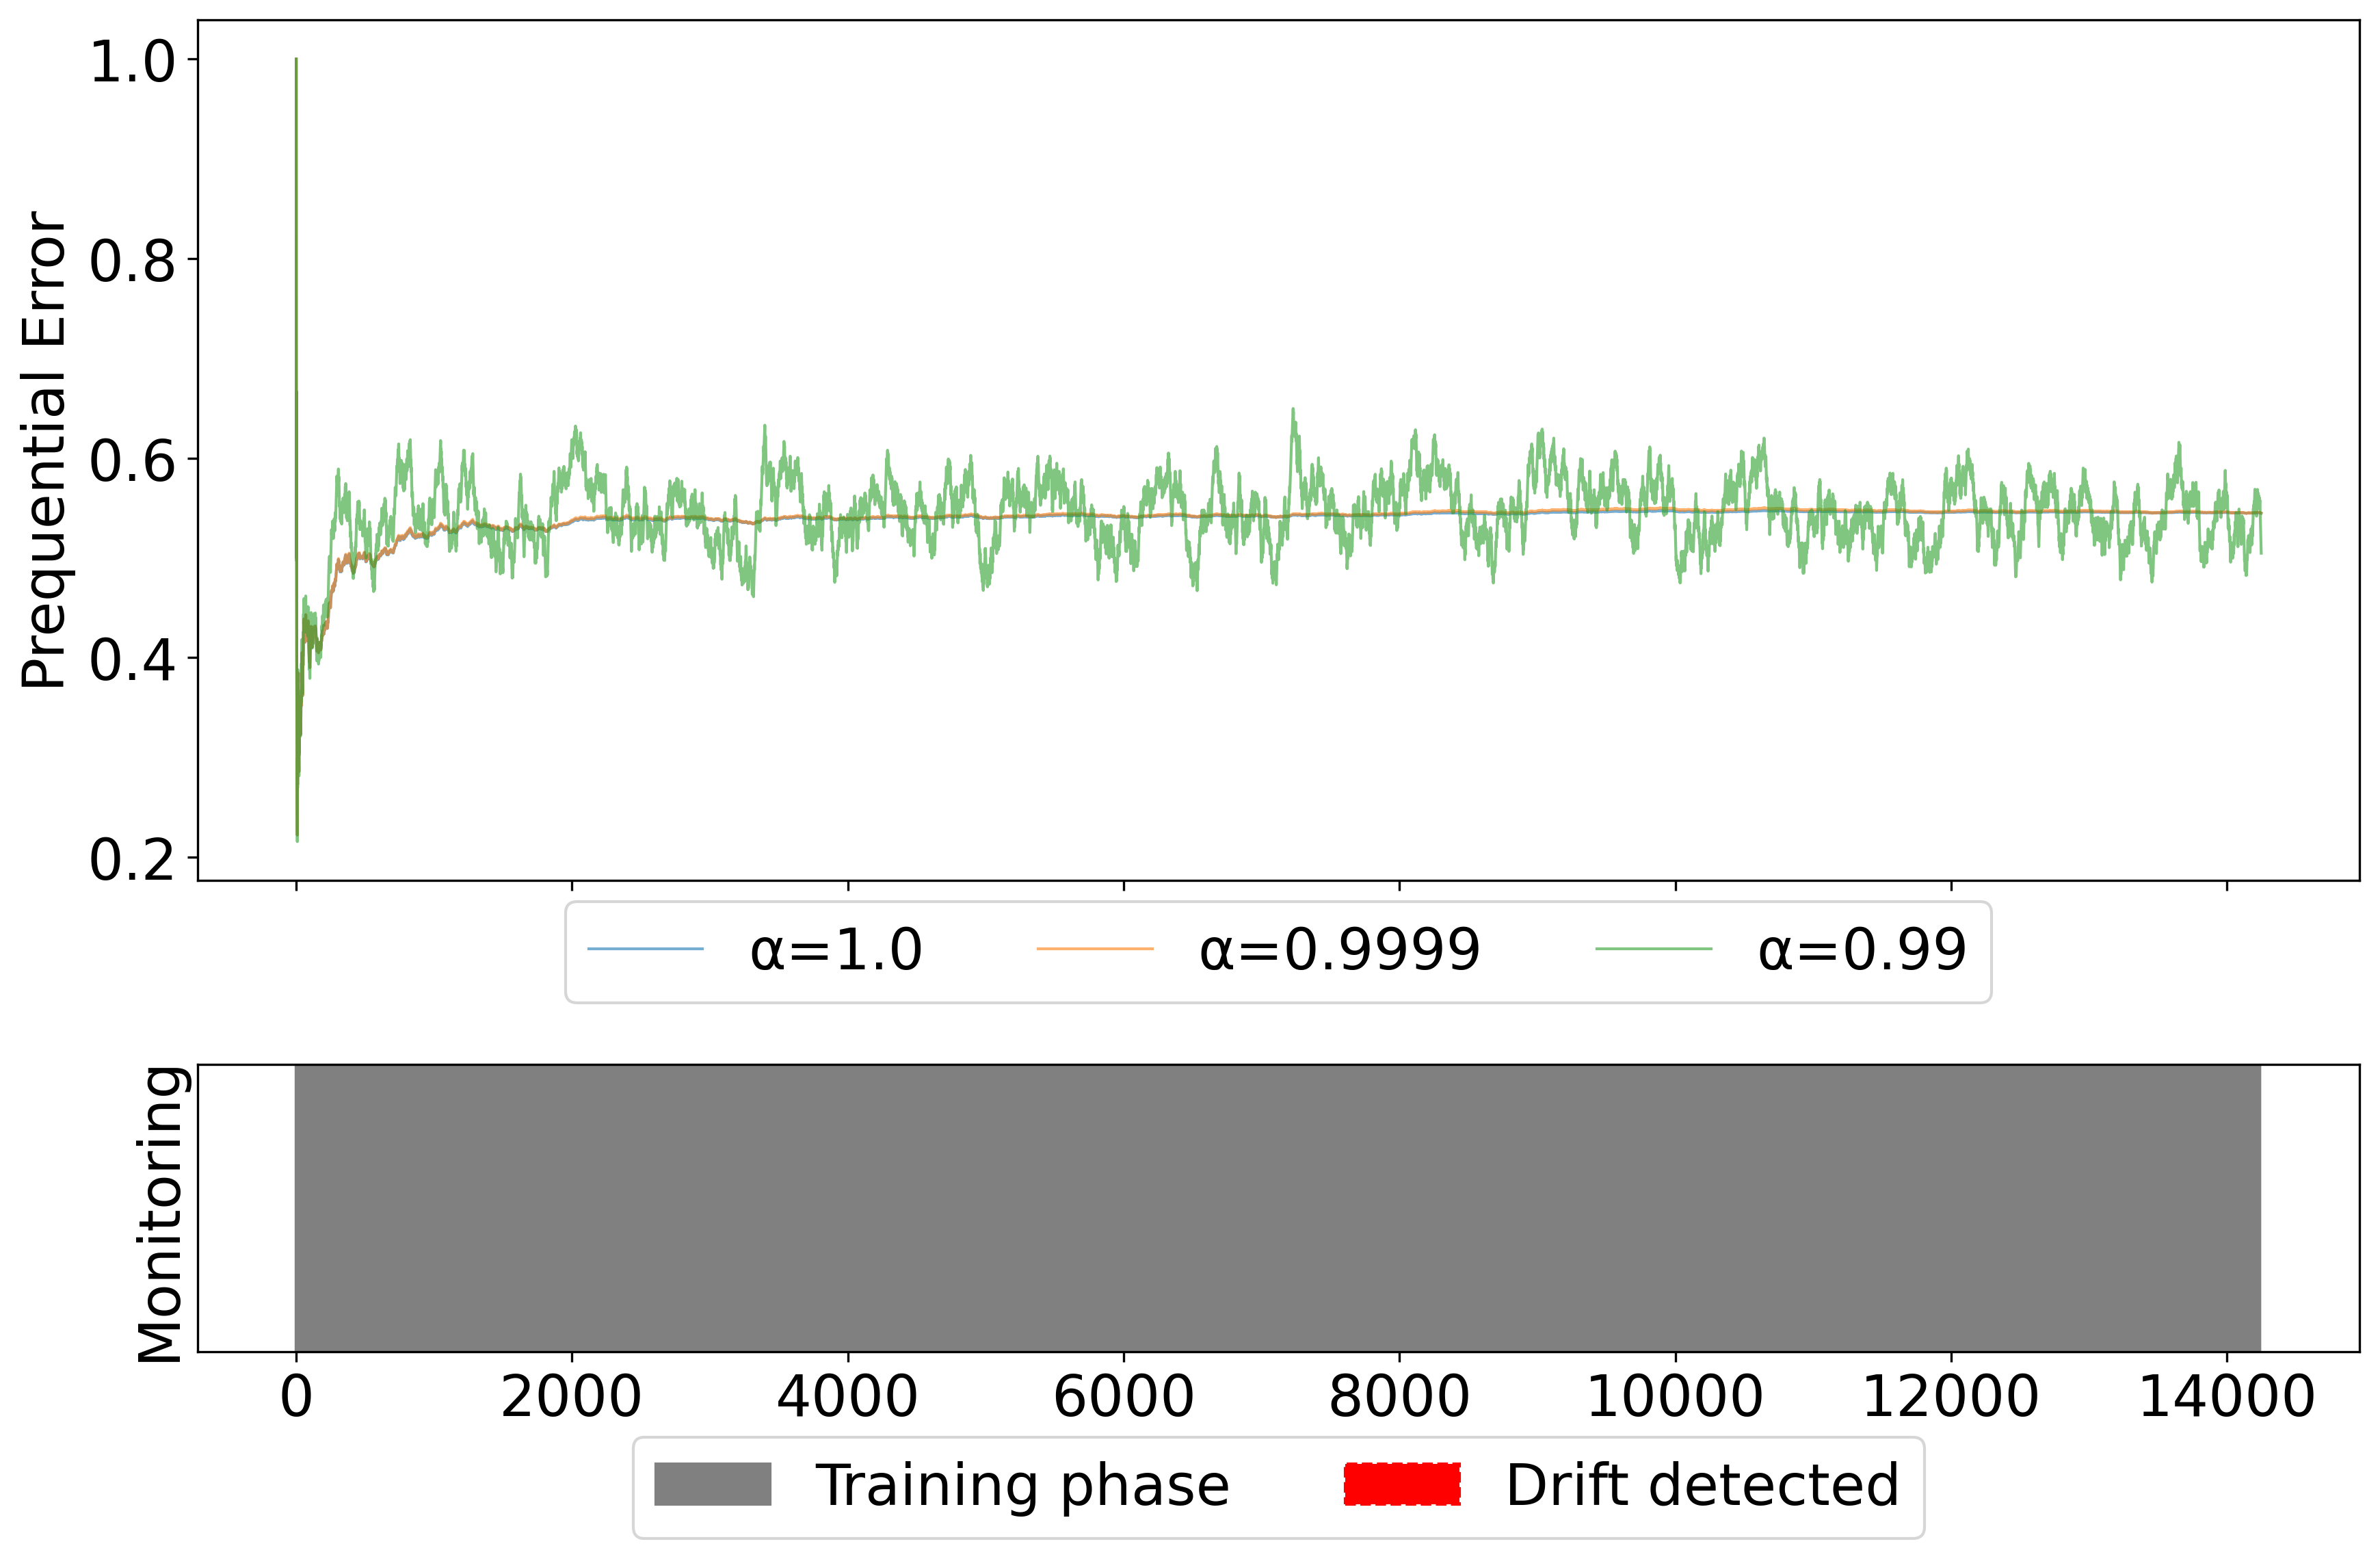

In [184]:
plt.rcParams.update({"font.size": 20})

alpha = 0.6
linewidth = 1.0

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    dpi=300,
    gridspec_kw={"height_ratios": [3, 1]},
)

for (metric_name, metric_values), linecolor in zip(
    metrics_historic_detector.items(),
    ["#1f77b4", "#ff7f0e", "#2ca02c"],
):
    ax[0].plot(
        metric_values,
        color=linecolor,
        linewidth=linewidth,
        alpha=alpha,
        label=metric_name,
    )

drift_color = "red"
drift_linestyle = "--"
warmup_color = "grey"

for idx in range(0, len(X_train)):
    ax[1].axvline(x=idx, color=warmup_color, linewidth=linewidth)

for idx in idx_drift:
    ax[1].axvline(x=idx, color=drift_color, linestyle=drift_linestyle, linewidth=1.5)

ax[0].set_ylabel("Prequential Error")
ax[0].legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.175),
    fancybox=True,
)
ax[1].set_yticks([])
ax[1].set_ylabel("Monitoring")
drift_path = mpatches.Patch(
    color=drift_color, label="Drift detected", linestyle=drift_linestyle
)
warmup_path = mpatches.Patch(color=warmup_color, label="Training phase")
ax[1].legend(
    handles=[warmup_path, drift_path],
    loc="upper center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    fancybox=True,
)

fig.tight_layout()
plt.show()